# Synthetic 1D inversion of Audio Magnetotelluric data


## 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cofi
from cofi_espresso import Magnetotelluric1D

In [2]:
mt = Magnetotelluric1D()

### Create synthetic data given a 5 layers Earth model

#### 0.1. Define a resistivity model and plot it

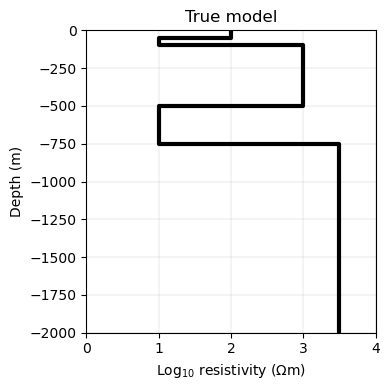

In [3]:
# layer electrical resitivity in log10 ohm.m 
true_model = np.array([2,1,3,1,3.5]) 
# depths in meters to the bottom of each layer (positive downwards), last layer infinite: len(true_depths)+1 = len(true_model)
true_depths = np.array([50,100,500,750])
# plot the model
max_depth=-2000
fig = mt.plot_model(true_model, true_depths, title='True model',max_depth = max_depth)

#### 0.2. Compute response of the model

In [4]:
#Define useful functions
from cofi_espresso._magnetotelluric_1D import get_frequencies, forward_1D_MT, z2rhophy, add_noise

Compute synthetic data, add noise, define the data / errors and plot

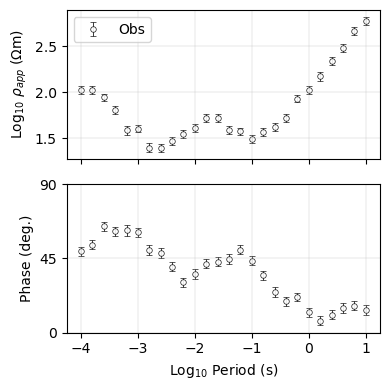

In [5]:
# define frequencies (in Hz) where responses are computed
fmin, fmax, f_per_decade = 1e-1, 1e4, 5
freqs = get_frequencies(fmin,fmax,f_per_decade)
# generate synthetic data 
# calculate impedance Z
Z = forward_1D_MT(true_model, true_depths, freqs, return_Z = True)
# add noise
Z, Zerr = add_noise(Z, percentage = 5, seed = 1234)
# transform Z to log10 apparent resistivity and phase (dobs)
dobs, derr = z2rhophy(freqs, Z, dZ=Zerr)
#set observed data
mt.set_obs_data(dobs, derr, freqs)
# plot the data
fig = mt.plot_data(mt.data, Cm = mt.covariance_matrix)

#### 0.3. Define a starting 1D mesh and model for the inversion

In [6]:
# the mesh used for the inversion contains many cells to produce a smooth model
nLayers, min_thickness, vertical_growth= 80, 5, 1.1
thicknesses = [min_thickness * vertical_growth**i for i in range(nLayers)]
starting_depths = np.cumsum(thicknesses)
starting_model = np.ones((len(starting_depths)+1)) * 2 # 100 ohm.m starting model (log10 scale) 
print('Model bottom: %.2f m'%starting_depths[-1])

Model bottom: 102370.01 m


#### 0.4. Set new starting model and mesh

In [7]:
mt.set_start_model(starting_model)
mt.set_start_mesh(starting_depths)

## 1. Define the problem

In [8]:
# get problem information from  espresso mt
model_size = len(mt.starting_model)         # number of model parameters
data_size = mt.data_size           # number of data points

In [9]:
# define CoFI BaseProblem
mt_problem = cofi.BaseProblem()
mt_problem.set_initial_model(mt.starting_model)

In [10]:
# add regularization: smoothing
smoothing_factor = 1
reg_smoothing = cofi.utils.QuadraticReg(smoothing_factor, model_size = model_size, reg_type = "smoothing")
reg = reg_smoothing
reg.model_size

81

In [11]:
def objective_func(logres, reg, depths = mt._dpstart):
    dpred = mt.forward(logres, depths=depths)
    data_misfit = mt.misfit(mt.data,dpred,mt.inverse_covariance_matrix)
    model_reg = reg(logres)
    return  data_misfit + model_reg

In [12]:
mt_problem.set_objective(objective_func, args=[reg, mt._dpstart])

In [13]:
#mt_problem.summary()

## 2. Define the inversion options

In [14]:
#mt_problem.suggest_tools();

In [15]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="L-BFGS-B",options={'ftol':1e-3,'maxiter': 100})
#my_options.summary()

In [16]:
#my_options.suggest_solver_params()

## 3.1 Start an inversion

In [17]:
inv = cofi.Inversion(mt_problem, my_options)
inv_result = inv.run()
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 1.3089532691328893
jac: [-1.47200697e-02  1.86146877e-02 -2.94588578e-02 -1.87368566e-02
  5.78195273e-03  1.32563961e-02 -6.81743555e-02 -1.08442189e-01
 -5.30379521e-02  4.38293848e-04  6.71867011e-03 -6.33233470e-03
  6.53068714e-03  3.82228251e-02  2.02457607e-02 -3.31324747e-02
 -4.02822445e-02  3.61652932e-03  2.67439406e-02  1.46017643e-02
  2.95570237e-03 -8.24504914e-03 -1.08278498e-02  2.35164556e-02
  5.01198419e-02  8.93030100e-03 -2.42643018e-02  1.39622759e-02
  4.06062075e-02  1.61983539e-02  7.47932831e-03  1.28029810e-02
 -8.05697736e-03 -1.17791777e-02  1.74304350e-02  8.97457669e-03
 -3.45956377e-02 -2.63544965e-02  2.03373097e-02  2.62864621e-02
  7.44673217e-03  7.93634052e-03 -4.42668127e-04 -2.12970975e-02
 -3.94007052e-03  2.87757375e-02  7.37507837e-03 -3.41165098e-02
 -1.98437268e-02  1.60960135e-02  9.84647925e-03 -4.14226433e-03
  1.25927491e-02  1.78205674e-02 -6.21356304e-03 -1.19689370

## 3.2 Plot inversion results

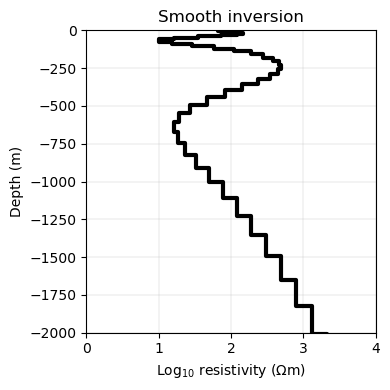

In [18]:
fig1 = mt.plot_model(inv_result.model, depths = mt._dpstart, max_depth = max_depth, title='Smooth inversion');            # inverted model

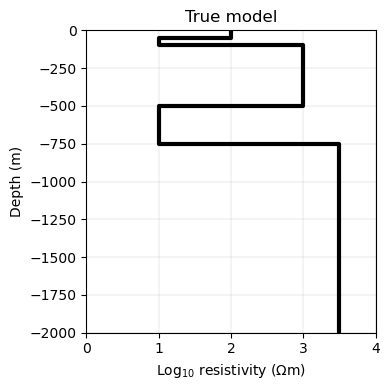

In [19]:
fig2 = mt.plot_model(true_model, true_depths, max_depth = max_depth, title='True model');       # true model

nRMSE = 1.011


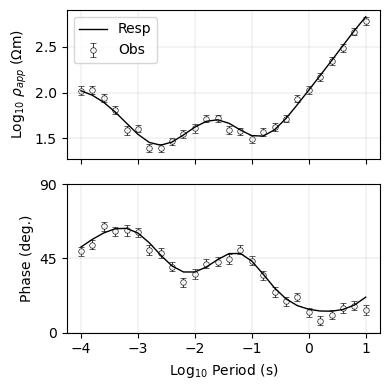

In [20]:
fig = mt.plot_data(mt.data, mt.forward(inv_result.model,depths=mt._dpstart), Cm = mt.covariance_matrix)
nRMSE = np.sqrt(mt.misfit(mt.data, mt.forward(inv_result.model,depths=starting_depths), Cm_inv = mt.inverse_covariance_matrix))
print('nRMSE = %.3f'%nRMSE)